# Salabim: PE Simulator 

In [1]:
# Add Priority Queue
# 221: Changed to Salabim version 21.1.5 to 22.0.2. Now has support for datetime!

In [2]:
import warnings

import random
import itertools
import simpy
import salabim as sim
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import os

from pathlib import Path

In [3]:
## Add backfilling for different priority jobs
## Ability to perform multiple backfilling on same time period

## Settings

In [4]:
# -------------------------------------
# General Settings
# -------------------------------------

CLUSTER_PE_AVAIL = 8  # Think about how this relates to job trace scaling ... Normally=5 vs but now changed to 1.

VERBOSE = False
TRACE = False


# -------------------------------------
# Old Job Generator Settings (not used)
# -------------------------------------

RAND_SEED = 42

# JOB_INTER = 1

# JOB_INTER_MEAN = 10 # minutes

# JOB_PE_REQ = 1
# JOB_RUN_TIME = 30
# SIM_TIME = 50

# priorities = '12'
# priorities_all = list(priorities) + ['all']

In [5]:
# Parameters
# path_base = r"/mnt/wsl/instances/Ubuntu-18.04/home/slurm/slurm_sim_ws/slurm_batches/simple_traces/srun"
path_base = r"/mnt/wsl/instances/Ubuntu-18.04//home/slurm/slurm_sim_ws/slurm_sim_tools/slurm_batches/simple_traces/srun"

run_type = 'srun8'
run_model = "salabim"

run_num = "run1"
run_name = f"srun8_prio2run-2jt1-3-prioprio-run30s-bRhotune2-rho60-500j-{run_num}"    # get from Thesis: models and variables
run_short = f"fiforun_2jt-run30-rho60-n500-{run_num}"   # name of graph

# SimPE Settings: 

QUEUE_TYPE = "Priority" # "FIFO"|"Priority"|"HighPE_Prio"|"Backfill"|"Backfill_Prio"

UPDATE_DATA_TO_FIFO = True # user, jobprio, sim_account

# Save
save_data = True
thesis_path = Path(".").absolute().parent
save_image_path = thesis_path / "images"
save_data_path = save_image_path / "data"

In [6]:
save_data_path

PosixPath('/home/overlytic/thesis/notebooks/visualise_runs/images/data')

In [7]:
# !ls $path_base | grep $run_type

## Job Roster from Trace

In [8]:
## Add backfilling for different priority jobs
## Ability to perform multiple backfilling on same time period

In [9]:
# Extract Batch Name
import re

p = re.compile('(.+)_([^_]+)$') # extract batch name from run_name (bit after last underscore)
batch_name = p.match(run_name).group(2)

# trace file
trace_filename = f"{run_type}_{batch_name}.csv"
trace_folder = "/mnt/wsl/instances/Ubuntu-18.04//home/slurm/slurm_sim_ws/slurm_sim_tools/slurm_batches/simple_traces/srun"
trace_path = os.path.join(trace_folder, trace_filename)

print(trace_path)

df_trace_raw = pd.read_csv(trace_path)

pd.options.display.max_columns=100

df_trace_raw.head()

/mnt/wsl/instances/Ubuntu-18.04//home/slurm/slurm_sim_ws/slurm_sim_tools/slurm_batches/simple_traces/srun/srun8_prio2run-2jt1-3-prioprio-run30s-bRhotune2-rho60-500j-run1.csv


,sim_job_id,sim_submit,sim_wclimit,sim_duration,sim_tasks,sim_tasks_per_node,sim_username,sim_submit_ts,sim_qosname,sim_partition,sim_account,sim_req_mem,sim_req_mem_per_cpu,sim_features,sim_gres,sim_shared,sim_cpus_per_task,sim_dependency,sim_cancelled_ts,freq,pe,job_prio,nodes_req,batch_name,batch_value,JOBINFO_INTERARRIVAL_TIME,JOBINFO_INTERARRIVAL_MEAN,JOBINFO_INTERARRIVAL_TYPE,CLUSTINFO_NODE_COUNT,CLUSTINFO_NODE_CPUS,CLUSTINFO_NODE_MEM_MB,CLUSTINFO_NODE_DEF_MEM_PER_CPU
0,1000,2020-01-01T12:00:03Z,2,70,3,3,user-001,1577880003,normal,training,training,22272,0,NaN,NaN,1,1,NaN,0,50,3,1,1,03_Inter_13.0,13,2.513031,13,exp+1,1,8,59392,7424
1,1001,2020-01-01T12:00:15Z,1,7,3,3,user-011,1577880015,normal,training,crucial,22272,0,NaN,NaN,1,1,NaN,0,50,3,10,1,03_Inter_13.0,13,12.172468,13,exp+1,1,8,59392,7424
2,1002,2020-01-01T12:00:20Z,1,8,1,1,user-001,1577880020,normal,training,training,7424,0,NaN,NaN,1,1,NaN,0,50,1,1,1,03_Inter_13.0,13,5.533483,13,exp+1,1,8,59392,7424
3,1003,2020-01-01T12:00:28Z,1,24,3,3,user-011,1577880028,normal,training,crucial,22272,0,NaN,NaN,1,1,NaN,0,50,3,10,1,03_Inter_13.0,13,7.590744,13,exp+1,1,8,59392,7424
4,1004,2020-01-01T12:00:41Z,1,6,1,1,user-011,1577880041,normal,training,crucial,7424,0,NaN,NaN,1,1,NaN,0,50,1,10,1,03_Inter_13.0,13,12.826609,13,exp+1,1,8,59392,7424


In [10]:
if UPDATE_DATA_TO_FIFO:
    print("**Before Fix:**")
    print(df_trace_raw.sim_username.unique())
    print(df_trace_raw.job_prio.unique())
    print(df_trace_raw.sim_account.unique())
    
    df_trace_raw.loc[df_trace_raw.sim_username == "user-011", 'sim_username'] = 'user-001'
    df_trace_raw.loc[df_trace_raw.sim_account == "crucial", 'sim_account'] = 'training'
    df_trace_raw.loc[df_trace_raw.job_prio == 10, 'job_prio'] = 1
    
    print("")
    print("**After Fix:**")
    print(df_trace_raw.sim_username.unique())
    print(df_trace_raw.job_prio.unique())
    print(df_trace_raw.sim_account.unique())

**Before Fix:**
['user-001' 'user-011']
[ 1 10]
['training' 'crucial']

**After Fix:**
['user-001']
[1]
['training']


In [11]:
# Check only 1 type of cluster info

csv_cols = df_trace_raw.columns.values.tolist()
clustinfo_cols = [x for x in csv_cols if x.startswith("CLUSTINFO")]

clust_params = (df_trace_raw
 .loc[:, clustinfo_cols]
 .drop_duplicates()
)

if clust_params.shape[0] != 1: raise Exception("Multiple Cluster parameters! Please Debug.")

# Display in table
(clust_params
 .reset_index()
 .melt(id_vars=['index'], value_vars=clustinfo_cols, var_name = "Parameter", value_name='Value')
 .drop(columns='index'))

,Parameter,Value
0,CLUSTINFO_NODE_COUNT,1
1,CLUSTINFO_NODE_CPUS,8
2,CLUSTINFO_NODE_MEM_MB,59392
3,CLUSTINFO_NODE_DEF_MEM_PER_CPU,7424


In [12]:
# df_trace_raw.head()

In [13]:
# Read Parameters
NODE_COUNT = clust_params.CLUSTINFO_NODE_COUNT.values[0]
NODE_CPUS = clust_params.CLUSTINFO_NODE_CPUS.values[0]
NODE_MEM_MB = clust_params.CLUSTINFO_NODE_MEM_MB.values[0]
DEFAULT_MEM_PER_CPU = clust_params.CLUSTINFO_NODE_DEF_MEM_PER_CPU.values[0]

def calc_pe_req(cpus_req, mem_req, nodes_req):
    pe_max = NODE_CPUS * NODE_COUNT
    
    job_pe_req = max([cpus_req / NODE_CPUS, mem_req / NODE_MEM_MB]) * nodes_req * NODE_CPUS
    
    return job_pe_req

def create_trace_format(df):
    
    df.rename(columns = {"sim_job_id" : "job_name"},inplace=True)
    
    if 'job_prio' in df.columns:
#         df.rename(columns = {"sprio_priority" : "job_prio"},inplace=True)
        pass
    else:
        warnings.warn('Missing Job Priority Column, assuming fifo so setting job_prio to decreasing!')
        df = df.assign(job_prio = lambda x: -1 * x.job_name)
    
        
    # Runtimes: Both in Seconds
    df['job_run_time'] = df.sim_duration
    df['job_walltime'] = df.sim_wclimit * 60   # walltime specified in min.
        
    # Calculate PE requested
    df['job_cpus_req'] = df.sim_tasks * df.sim_cpus_per_task
    df['default_mem_req'] = df.job_cpus_req * DEFAULT_MEM_PER_CPU
    df['job_mem_req'] = df.sim_req_mem.fillna(df.default_mem_req)
    df['job_nodes_req'] = df.nodes_req # df.sim_tasks / df.sim_tasks_per_node
    
    df['job_pe'] = df.apply(lambda x: calc_pe_req(x.job_cpus_req, x.job_mem_req, x.job_nodes_req), axis=1)
          
    # Date times
    df['job_entertime_ts'] = df.sim_submit_ts
    df['job_entertime'] = pd.to_datetime(df.sim_submit_ts, unit='s')
    
    # Select columns
    df = (df
          .sort_values(['job_entertime', 'job_name'], ascending=[True,True])
          .assign(job_number = lambda x: x.index)
          .loc[:, ['job_number', 'job_name', 'job_pe', 'job_prio', 'job_run_time', 'job_walltime', 
                    "job_entertime", 
                    #"job_entertime_ts", 
                    # "job_cpus_req", "job_mem_req", "job_nodes_req"
#                     "job_interarrival_mean"
                   "batch_name",
                   "batch_value"
                   ]]
         )
          
    return(df)
    
# Create job trace dataframe
df_job_trace = (df_trace_raw
            .pipe(create_trace_format)
           )

# Convert to dictionary
job_trace = df_job_trace.to_dict(orient='records')

df_job_trace.head()
df_job_trace.tail()

## AADD PRIORITY THINGIES!!!

,job_number,job_name,job_pe,job_prio,job_run_time,job_walltime,job_entertime,batch_name,batch_value
495,495,1495,1.0,1,67,120,2020-01-01 13:58:20,03_Inter_13.0,13
496,496,1496,1.0,1,16,60,2020-01-01 13:58:21,03_Inter_13.0,13
497,497,1497,3.0,1,18,60,2020-01-01 13:58:35,03_Inter_13.0,13
498,498,1498,1.0,1,13,60,2020-01-01 13:58:41,03_Inter_13.0,13
499,499,1499,1.0,1,7,60,2020-01-01 13:59:01,03_Inter_13.0,13


# Create Custom Job Trace (roster) -> not used

In [14]:
# sum(type_freq)

In [15]:
# np.array(type_array)
# used_type_idx[0]

In [16]:
shuffle_seed = 42

run_descript = 'pe1_pe5_diff_prio'

shuffle_type = "random"
shuffle_type = "alternate"

job_type_count = 5

job_types = {}

job_types[0] = {'job_pe' : 1 , 'job_prio': 10, 'job_run_time': 3}
job_types[1]=  {'job_pe' : 1, 'job_prio': 10, 'job_run_time': 4}
job_types[2] = {'job_pe' : 1, 'job_prio': 10, 'job_run_time': 5}
job_types[3] = {'job_pe' : 4, 'job_prio': 200, 'job_run_time': 5}
job_types[4] = {'job_pe' : 5, 'job_prio': 100, 'job_run_time': 5}

type_list = [x for x in range(job_type_count)]
type_freq = [20,20,20,20,20]
# type_freq = [0,100,0,0,0]


In [17]:
# Make Job Roster: Helper Functions

def rename_job_type_field(job_types, curr_field, new_field):

    """Renames a job_type field e.g. job_prio to job_priority"""
    
    for i in job_types:
        curr_type = job_types[i]
        renamed_type = {}

        for k, v in curr_type.items():
            if k == curr_field:
                k = new_field

            renamed_type[k] = v

        job_types[i] = renamed_type

    return(job_types)


# Write a job roster function ... 

def make_job_roster(job_types, type_freq, n = None, 
                    shuffle_type = "random", shuffle_seed = 42, 
                    roster_format = None,
                    convert_to_df = False,
                    add_job_name = True,
                    add_job_enter_time = False):
    
    """
    Creates a job roster from a number of job types
    
    type_freq : number of jobs of each type
    
    shuffle_type : "random"
                   "alternate"  e.g. 1,2,3,1
                   
    roster_format:  pending -> for Pending Queue format, output as Dataframe
                    active -> for Active Queue format, output as Dataframe
                    
    convert_to_df:  converts output to dataframe
    
    """

    job_type_count = len(job_types)
    
    type_list = [x for x in range(job_type_count)]    
    # type_freq = [0,100,0,0,0]
    
    if not n is None:
        type_freq = np.round(np.array(type_freq) / np.sum(type_freq) * n)
        type_freq = [int(x) for x in type_freq]

    if roster_format == "pending":
        add_job_enter_time = True
        convert_to_df = True
        
        # Fix job type names
        job_types = rename_job_type_field(job_types, "job_prio", "job_priority")
        job_types = rename_job_type_field(job_types, "job_run_time", "job_runtime")
        
        
    all_jobs = []
    job_roster = []

    if shuffle_type == "random":

        for j_type, freq in zip(type_list, type_freq):
            # print(f"{type} {freq}")
            for _ in range(freq):
                all_jobs.append(j_type)

        random.Random(shuffle_seed).shuffle(all_jobs)

        for i, jt in enumerate(all_jobs):
            job = {}
            
            # Add Starting Columns
            if add_job_name:
                job['job_name'] = i
            
            # Add job_type details
            job.update(job_types[jt])
            
            # Add Columns add end
            if add_job_enter_time:
                job['job_entertime'] = i+1
                
                # Example code for changing to datetime! (See 221 notebook for test)
                # start_date = datetime.datetime(2020,11,1,12,0,0)
                # delta_hours = datetime.timedelta(minutes=i**2)
                # job['job_entertime'] = start_date + delta_hours
            
            
            # Add to roster
            job_roster.append(job)

    elif shuffle_type == "alternate": ## ignores type_freq.. assumes equal proportions

        type_array = np.array(type_freq)        
        used_type_idx = np.where(type_array > 0)[0]
        used_type_counts = len(used_type_idx)    
        batches = int(type_array.sum() / used_type_counts)
        
        count = 0
        for i in range(batches):
            count += 1
            for j in used_type_idx:
                job = {}                                
                
            # Add Starting Columns
            if add_job_name: 
                job['job_name'] = i                            
            
            # Add job_type details
            job.update(job_types[jt])
            
            # Add Columns add end
            if add_job_enter_time:
                job['job_entertime'] = i+1
                
                # Example code for changing to datetime! (See 221 notebook for test)
                # start_date = datetime.datetime(2020,11,1,12,0,0)
                # delta_hours = datetime.timedelta(minutes=i**2)
                # job['job_entertime'] = start_date + delta_hours
            
            # Add to roster
            job_roster.append(job)
            
    if convert_to_df:
        job_roster = pd.DataFrame(job_roster)
                
    return(job_roster)

def add_job_entertime(job_roster):
    
    """Adds a simple job enter time column to a job roster
    
       Currently delay between job is 1 second, starting at 1.
    """
    
    new_roster = job_roster.copy()
    
    for i, job in enumerate(job_roster):
        job['job_entertime'] = i+1
        
        # Example code for changing to datetime! (See 221 notebook for test)
        # start_date = datetime.datetime(2020,11,1,12,0,0)
        # delta_hours = datetime.timedelta(minutes=i**2)
        # job['job_entertime'] = start_date + delta_hours
        
    return(new_roster)

In [18]:
job_roster = make_job_roster(job_types, type_freq, n = 100, roster_format = 'pending')

job_roster.head()

,job_name,job_pe,job_priority,job_runtime,job_entertime
0,0,1,10,5,1
1,1,1,10,5,2
2,2,5,100,5,3
3,3,1,10,3,4
4,4,4,200,5,5


# Backfill Scheduler: Helper Functions

In [19]:
def activeQ_to_df(activeQ):
    act_list = activeQ.as_list()
    
    act_dic = [{"job_name" : j.name(),
              "job_pe" : j.pe,
              "job_priority" : j.prio,
              "job_runtime" : j.run_time,
              "job_start" : j.enter_time(activeQ)} for j in act_list]

    act_df = (pd.DataFrame(act_dic)
              .reset_index(drop=True)
             )
    
    if act_df.shape[0] > 0:
        act_df = (act_df
                  .eval('job_end = job_start + job_runtime')
                  .sort_values(['job_end', 'job_priority'],
                               ascending = [True, False])
                 )
    
    return(act_df)


def pendingQ_to_df(pendingQ, sort = False, sort_columns = None, sort_asc=None):
    
    if sort_columns is None:
        sort_columns = SORT_COLUMNS
        
    if sort_asc is None:
        sort_asc = SORT_ASC
    
    q_list = pendingQ.as_list()
    q_dic = [{"job_name" : j.name(),
              "job_pe" : j.pe,
              "job_priority" : j.prio,
              "job_runtime" : j.run_time,
              "job_entertime" : j.enter_time(pendingQ)} for j in q_list]

    # convert q_list to dataframe
    q_df = (pd.DataFrame(q_dic)
            .reset_index(drop = True)                            
           )
    
    # sort queue
    if sort:
        q_df = q_df.sort_values(sort_columns, ascending=sort_asc)
    
    return(q_df)


def move_pending_to_active(job_name, pending_df, active_df, time):

#     str_num = f"job.{num}"
    
    df_item = pending_df[pending_df.job_name == job_name].copy()
    pending_df = pending_df[pending_df.job_name != job_name].copy()
    
    dic_item = {"job_name" : df_item.job_name.values[0],
              "job_pe" : df_item.job_pe.values[0],
              "job_priority" : df_item.job_priority.values[0],
              "job_runtime" :  df_item.job_runtime.values[0],
              "job_start" : time,
              "job_end" : time + df_item.job_runtime.values[0]}
    
    active_df = pd.concat([active_df,
                           pd.DataFrame(dic_item, index= [active_df.index.max()+1])], 
                          axis = 0)
    
    active_df = active_df.reset_index(drop = True)
    
    return pending_df, active_df

def build_schedule(t, avail_pe, pending_df, active_df, verbose=False):
    
    # Read Queues to df
    # act_df = activeQ_to_df(activeQ)
    # q_df = pendingQ_to_df(pendingQ)
    
    # Initialise Schedule
    
    sched = []
    index = 0        

    item =  {"t" : float(t),
             "delta_pe" : 0,
             "pe_avail" : avail_pe,             
             "type" : "init",
             "job_number": np.nan,
             "job_prio" : np.nan,
             "job_pe" : np.nan}
    
    sched.append(item)
    
    curr_avail_pe = avail_pe
    t_now = t
    count = 0
    
    while (len(pending_df) + len(active_df) > 0) and (count <= 100):
        hasJobComplete = False
        hasPendingStart = False
        
        if verbose: print(f"count: {count}, time: {t_now}")
        
        # Sort Queues
        
        if len(active_df) > 0:
            active_df = active_df.sort_values(['job_end', 'job_priority'],
                               ascending = [True, False])
        
        if len(pending_df) > 0:
            pending_df = pending_df.sort_values(SORT_COLUMNS, ascending=SORT_ASC)
        
        # Active Queue: Check Job Completion
        
        if len(active_df) > 0:
            next_active_end = active_df.job_end.values[0]
            
            if next_active_end <= t_now: 
                hasJobComplete = True
                
            if verbose: print(f"hasJobComplete: {hasJobComplete}. next_active_end: {next_active_end}")
                
        if hasJobComplete:
            complete_job_name = active_df.job_name.values[0]
            complete_job = active_df[active_df.job_name == complete_job_name]
            active_df = active_df[active_df.job_name != complete_job_name]
            
            curr_avail_pe = curr_avail_pe + complete_job.job_pe.values[0]
            
            item =  {"t" : float(complete_job.job_end.values[0]),
                     "delta_pe" : complete_job.job_pe.values[0],
                     "pe_avail" : curr_avail_pe ,             
                     "type" : "end",
                     "job_number": complete_job.job_name.values[0],
                     "job_prio" : complete_job.job_priority.values[0],
                     "job_pe" : complete_job.job_pe.values[0],
                     "job_runtime" : complete_job.job_runtime.values[0]}
    
            sched.append(item)
            
        # Pending Queue: Check for next job to execute
        
#         pending_df_filtered = pending_df[pending_df.job_entertime]
    
        if len(pending_df) > 0:
            next_pending_pe = pending_df.job_pe.values[0]
            
            if next_pending_pe <= curr_avail_pe: 
                hasPendingStart = True

            if verbose: print(f"hasPendingStart: {hasPendingStart}. pe_req: {next_pending_pe}, avail_pe: {curr_avail_pe}")

            
        if hasPendingStart:
            pending_job_name = pending_df.job_name.values[0]
            pending_job = pending_df[pending_df.job_name == pending_job_name]
            
            curr_avail_pe = curr_avail_pe - pending_job.job_pe.values[0]
            
            if verbose: 
                print(f"Before Starting Job {pending_job.job_name.values[0]}")
                print(pending_df)
                print(active_df)
            
            pending_df, active_df = move_pending_to_active(pending_job_name, pending_df, active_df, t_now)
            
            if verbose: 
                print(f"After Starting Job {pending_job.job_name.values[0]}")
                print(pending_df)
                print(active_df)
            
            item =  {"t" : t_now,
                     "delta_pe" : pending_job.job_pe.values[0],
                     "pe_avail" : curr_avail_pe ,             
                     "type" : "start",
                     "job_number": pending_job.job_name.values[0],
                     "job_prio" : pending_job.job_priority.values[0],
                     "job_pe" : pending_job.job_pe.values[0],
                     "job_runtime" : pending_job.job_runtime.values[0]}
    
            sched.append(item)
        
        
        # Increment Time
        count += 1
        t_now = t_now + 1  # 1 second
        
    # Calc PE Available

    df_sched = pd.DataFrame(sched)
    # df_sched['pe_avail'] = df_sched.delta_pe.cumsum() + avail_pe
    
    # print
    return df_sched


def max_backfill_runtime(df_sched, job_pe, job_priority):

    """Calculates the maximum amount of time a specific job that is being backfilled can run
       before being blocked by a higher priority job
    """
    
    init_pe = df_sched[df_sched.type == "init"].pe_avail[0]
    
    if job_pe > init_pe:
        return(0)
    
    df_sched2 = (df_sched
                 [(df_sched.job_prio >= job_priority) | 
                  (df_sched.job_prio.isna())]
                 .copy()
                )
    
    sched_times = df_sched2.t.values
    sched_pe_avail = df_sched2.pe_avail.values
    sched_cum_min = df_sched2.pe_avail.cummin().values
    idx_valid = np.argwhere(sched_cum_min>=init_pe)
    max_run_time = sched_times[idx_valid[-1]] - sched_times[0]
    
    return(max_run_time)

In [20]:
#

In [21]:
# df_sched

In [22]:
# # TESTING CODE

# if not pendingQ is None:

#     init_pe = 1
#     prio_level = 50 # For the job... 
    
#     df_sched = build_schedule(3, init_pe, pendingQ_to_df(pendingQ), activeQ_to_df(activeQ))

#     display(df_sched)
    
#     # Calculate the longest time period
    
#     df_sched2 = (df_sched
#                  [(df_sched.job_prio >= prio_level) | 
#                   (df_sched.job_prio.isna())]
#                  .copy()
#                 )
    
#     sched_times = df_sched2.t.values
#     sched_pe_avail = df_sched2.pe_avail.values
#     sched_cum_min = df_sched2.pe_avail.cummin().values
#     idx_valid = np.argwhere(sched_cum_min>=init_pe)
#     max_run_time = sched_times[idx_valid[-1]] - sched_times[0]
    
#     print(sched_pe_avail)
#     print(sched_cum_min)
#     print(idx_valid)
#     print(idx_valid[-1])
#     print(max_run_time)

In [23]:
# q_df

In [24]:
# job_roster[1]['job_entertime']

In [25]:
# ?sim.__version__


In [26]:
# sim.Environment()

In [27]:
# job_roster[1]['job_entertime']

In [28]:
# env.datetime_to_t(job_roster[1]['job_entertime'])

## Simulation: Using Job Trace

In [29]:
# env.datetime_to_t(job_trace.job_entertime[0])

In [30]:
# job_trace.job_entertime

In [31]:
# Roster Version

import salabim as sim

class JobReader(sim.Component):
    def process(self, job_roster):
        for job_spec in job_roster:
            # Option1: Random
            # yield self.hold(sim.Exponential(mean=JOB_INTER_MEAN).sample()) # self.hold(JOB_INTER)            
            
            # Option2: Specific float time from file
            # Job(at=job_spec['job_entertime'], job_spec=job_spec)
            
            # Option3: Specific datetime!
            yield self.hold(till=env.datetime_to_t(job_spec['job_entertime']))
            Job(job_spec=job_spec)

class Slurm(sim.Component):
    def process(self):
        while True:
            run_again = False # Should loop until most pe possible is used by pending jobs
            
            if len(pendingQ) > 0:
                
                avail_pe = res.available_quantity()
                slurm_comment = ""
                
                # Read Active Queue
                a_df = activeQ_to_df(activeQ)
                
                # Read Pending Queue
                q_df = pendingQ_to_df(pendingQ)

                # Get index of job                
                pop_index = q_df.sort_values(SORT_COLUMNS, ascending=SORT_ASC).index[0].tolist()
                pe_req = pendingQ[pop_index].pe
                
                if VERBOSE: 
                    print(q_df.sort_values(SORT_COLUMNS, ascending=SORT_ASC))
                    print("")
                
                if QUEUE_TYPE == "Backfill" and pe_req > avail_pe:
                    env.print_trace("","",f"""Enter backfill if statement. 
                                          job number: {pendingQ[pop_index].name()}
                                          job prio: {pendingQ[pop_index].prio}
                                          job pe: {pe_req}
                                          avail pe: {avail_pe}""")
                                    
                    q_df = q_df.assign(can_run = q_df.job_pe <= avail_pe)
                        
                    if len(q_df) > 0:
                        
                        canrun_jobs_df = (q_df
                                     .query('can_run == True')
                                     .sort_values(SORT_COLUMNS, ascending=SORT_ASC))
                        
                        if len(canrun_jobs_df) > 0:
                                    
                            env.print_trace("","",f"Performing a backfill")

                            pop_index = canrun_jobs_df.index[0].tolist()                            
                            slurm_comment = "Backfill"
                            pe_req = pendingQ[pop_index].pe
                                    
                            env.print_trace("","",f"""New job to backfill. 
                                                  job number: {pendingQ[pop_index].name()}
                                                  job prio: {pendingQ[pop_index].prio}
                                                  job pe: {pe_req}
                                                  avail pe: {avail_pe}""")
                
                
                if QUEUE_TYPE == "Backfill_Prio" and pe_req > avail_pe:
                    env.print_trace("","",f"""Enter backfill if statement. 
                                          job number: {pendingQ[pop_index].name()}
                                          job prio: {pendingQ[pop_index].prio}
                                          job pe: {pe_req}
                                          avail pe: {avail_pe}""")
                                                        
                    sched_df = build_schedule(env.now(), avail_pe, q_df, a_df)
                    
                    q_df['max_bf_runtime'] = q_df.apply(lambda x:
                                                      max_backfill_runtime(sched_df,
                                                                           x.job_pe,
                                                                           x.job_priority),
                                                      axis = 1)
                    
                    # calc max backfill runtime...
                    
                    if len(q_df) > 0:
                        
                        canrun_jobs_df = (q_df
                                     .assign(can_backfill = q_df.job_runtime <= q_df.max_bf_runtime)
                                     .query('can_backfill == True')                                     
                                     .sort_values(SORT_COLUMNS, ascending=SORT_ASC))
                        
                        if len(canrun_jobs_df) > 0:
                                    
                            env.print_trace("","",f"Performing a backfill")
                            
                            pop_index = canrun_jobs_df.index[0].tolist()
                            slurm_comment = "Backfill"
                            pe_req = pendingQ[pop_index].pe
                                    
                            env.print_trace("","",f"""New job to backfill. 
                                          job number: {pendingQ[pop_index].name()}
                                          job prio: {pendingQ[pop_index].prio}
                                          job pe: {pe_req}
                                          avail pe: {avail_pe}""")
                            
                            canrun_jobs_df = (canrun_jobs_df
                                     .drop(index=pop_index)
                                     .assign(can_backfill_again = canrun_jobs_df.job_pe + pe_req <= avail_pe)
                                     .query('can_backfill_again == True')
                                     .sort_values(SORT_COLUMNS, ascending=SORT_ASC))
                            
                            if len(canrun_jobs_df) > 0:
                                # Has another job to backfill
                                env.print_trace("","",
                                                f"""T {env.now()}: Slurm has another possible backfill: 
                                                runagain = True""")
                                
                                run_again = True
                            

                if pe_req <= avail_pe:
                    self.job = pendingQ.pop(pop_index)
                    self.job.slurm_comment = slurm_comment
                    
                    env.print_trace("","",f"T {env.now()}: Slurm picks Job: {self.job.sequence_number()}")                    
                    self.job.activate()

                    # See if enought pe left for another job:
                    
                    q_df2 = (q_df
                            .drop(index=pop_index)
                            .assign(can_run_again = q_df.job_pe + pe_req <= avail_pe)
                            .query("can_run_again == True")
                            .copy()
                           )
                    
                    if len(q_df2) > 0 :
                        
                        run_again = True
                    
                        env.print_trace("","",
                                        f"""T {env.now()}: Slurm has another possible job to run: 
                                        runagain = True""")

                    
                    
            if not run_again:
                yield self.passivate()
            

class Job(sim.Component):
    def setup(self, job_spec):
        self.pe = job_spec['job_pe']
        self.prio = job_spec['job_prio'] # higher number -> better priority
        self.run_time = job_spec['job_run_time']
        self.slurm_comment = ""
        
    def process(self):
        env.print_trace("","",f"Received a Job: {self.sequence_number()}, PE: {self.pe}, Priority: {self.prio}")
        job_submit_mon.tally(self.sequence_number())
        
        job_prio_mon.tally({'job_number': self.sequence_number(), 
                            'job_prio' : self.prio})
        
        job_pe_req_mon.tally({'job_number': self.sequence_number(), 
                              'job_pe_req' : self.pe})
        
        avail_pe_mon.tally({'job_number': self.sequence_number(), 
                            'pe_avail' : res.available_quantity()})
            
        self.enter_sorted(pendingQ, -1*self.prio)
        
        if slurm.ispassive():
            slurm.activate()
            
        yield self.passivate()
        
        # Store Slurm comment
        job_slurm_comment_mon.tally({'job_number': self.sequence_number(), 
                                     'slurm_comment' : self.slurm_comment})
        
        # Request Job Resources
        yield self.request(ticket)
        yield self.request((res, self.pe))
        self.release(ticket)                
        
        # Run Job
        env.print_trace("","",f"Started Running Job: {self.sequence_number()}, PE: {self.pe}, Priority: {self.prio}")
        self.enter(activeQ)         
        job_start_mon.tally(self.sequence_number())
        
        # Running Time
        yield self.hold(self.run_time)        
        
        # Completed Job
        job_end_mon.tally(self.sequence_number())
        self.leave(activeQ)
        self.release(res)
        
        if slurm.ispassive():
            slurm.activate()
            
        env.print_trace("","",f"Finished Running Job: {self.sequence_number()}, PE: {self.pe}, Priority: {self.prio}")

# env = sim.Environment(datetime0=True, trace = False)
# start_time = job_roster[0]['job_entertime'] - datetime.timedelta(seconds=1)

env = sim.Environment(datetime0=True, trace=False)

pendingQ = sim.Queue("pendingQ")
activeQ = sim.Queue("activeQ")

ticket = sim.Resource("ticket")
res = sim.Resource("res", capacity=CLUSTER_PE_AVAIL)

slurm = Slurm()

job_submit_mon = sim.Monitor()
job_start_mon = sim.Monitor()
job_end_mon = sim.Monitor()
job_pe_req_mon = sim.Monitor()
job_prio_mon = sim.Monitor()
job_slurm_comment_mon = sim.Monitor()
avail_pe_mon = sim.Monitor()

# Roster

JobReader(job_roster=job_trace)

# BACKFILLING TESTING ROSTER
# {'job_pe' : 1 , 'job_prio': 10, 'job_run_time': 10}

# # Example 1
# res = sim.Resource("res", capacity=5)
# run_descript = "failed_bf_same_time"

# Job(at=1.00, job_spec = {'job_pe' : 4, 'job_prio' : 100, 'job_run_time' : 5}) # expected finish... 6
# Job(at=2.00, job_spec = {'job_pe' : 5, 'job_prio' : 150, 'job_run_time' : 5}) # higher priority. expected start ... 6
# Job(at=3.00, job_spec = {'job_pe' : 1, 'job_prio' : 100, 'job_run_time' : 3}) # this should be backfilled . expected start 3.. finish at 6
# Job(at=3.00, job_spec = {'job_pe' : 1, 'job_prio' : 100, 'job_run_time' : 3}) # this should be backfilled . expected start 3.. finish at 6

# # Example 2

# delta = 20

# Job(at=delta + 1.00,  job_spec = {'job_pe' : 4, 'job_prio' : 100, 'job_run_time' : 5})
# Job(at=delta + 2.00,  job_spec = {'job_pe' : 5, 'job_prio' : 150, 'job_run_time' : 5}) # higher priority
# Job(at=delta + 3.00,  job_spec = {'job_pe' : 1, 'job_prio' : 100, 'job_run_time' : 4}) ## backfill start... 3... backfill finish... 7
#                                                                                        ## this should not be backfilled ... 
#                                                                                        ## since will delay job 2 (pe 5)

# Job(at=delta + 3.01,  job_spec = {'job_pe' : 1, 'job_prio' : 100, 'job_run_time' : 4})

# # Idee: Laai sommer direk in job_roster... 

# Queue Parameters
# QUEUE_TYPE = "FIFO"
# QUEUE_TYPE = "Priority"
# QUEUE_TYPE = "Backfill"
# QUEUE_TYPE = "Backfill"
# QUEUE_TYPE = "Backfill_Prio"

# Queue Sorting
    
if QUEUE_TYPE == "FIFO":
    SORT_COLUMNS = ['job_entertime']
    SORT_ASC = [True]
    
if QUEUE_TYPE == "LIFO":
    SORT_COLUMNS = ['job_entertime']
    SORT_ASC = [False]
    
elif QUEUE_TYPE == "Priority":
    SORT_COLUMNS = ['job_priority', 'job_entertime']
    SORT_ASC = [False, True]

elif QUEUE_TYPE == "HighPE_Prio":
    SORT_COLUMNS = ['job_pe', 'job_priority']
    SORT_ASC = [False, False]
    
elif QUEUE_TYPE == "Backfill":
    SORT_COLUMNS = ['job_priority', 'job_entertime']
    SORT_ASC = [False, True] # Highest Priority, then First entry time.

elif QUEUE_TYPE == "Backfill_Prio":
    SORT_COLUMNS = ['job_priority', 'job_entertime']
    SORT_ASC = [False, True] # Highest Priority, then First entry time.
    
else: 
    print("Please set the QUEUE_TYPE variable!")
    SORT_COLUMNS = []
    SORT_ASC = [] 

# env.run(till=3)
env.run()

In [32]:
# activeQ.print_info()
# pendingQ.print_info()
# activeQ_to_df(activeQ)

In [33]:
# pendingQ_to_df(pendingQ)

In [34]:
# (act_df
#  .reset_index(drop=True)
#  .assign()
#  .assign(job_batch = 0)
# )

In [35]:
# act_df

In [36]:
# for index, job in act_df.iterrows():
#     print(job)

In [37]:
# q_df.job_entertime.shift(fill_value=3)

In [38]:
# df_sched.delta_pe.cumsum()+5

In [39]:
# pd.DataFrame(sched).pe_avail.shift(-1, fill_value = 3)

# df_sched = pd.DataFrame(sched)
# df_sched['pe_avail'] = df_sched.delta_pe.cumsum() + pe_avail

# df_sched


In [40]:
# len(act_df)
# len(q_df)

In [41]:
# q_df2 = q_df.copy() 

# num = 1
# str_num = f"job.{num}"
# q_df2[q_df2.job_name == str_num]

In [42]:
# pd.concat(act_df.

In [43]:
# pendingQ.as_list()

In [44]:
# activeQ.as_list()

In [45]:
# q_df = pendingQ_to_df(pendingQ)

# q_df.set_index(['job_priority', 'job_entertime']).sort_index([True, False])

In [46]:
# avail_pe = res.available_quantity()
# slurm_comment = ""


# df_sched = build_schedule(3, 1, pendingQ_to_df(pendingQ), activeQ_to_df(activeQ), verbose = False)

# df_sched

In [47]:
# job_roster

In [48]:
# job_roster_pendingq = []

# for i, j in enumerate(job_roster):
#     new_item = {"job_name" : i,
#               "job_pe" : j['job_pe'],
#               "job_priority" : j['job_prio'],
#               "job_runtime" :  j['job_run_time'],
#               "job_entertime" : i+1}
    
#     job_roster_pendingq.append(new_item)
    
# df_pending_test = pd.DataFrame(job_roster_pendingq)

# df_pending_test

In [49]:
# df_active_test = activeQ_to_df(activeQ)

# df_active_test

In [50]:
# df_pending_test

In [51]:
# SORT_COLUMNS = ['job_entertime', 'job_priority'] # MAW FIFO op oomblik ...
# SORT_ASC = [True, False]

# df_sched = build_schedule(0, 5, df_pending_test, df_active_test, verbose = False)

# SORT_COLUMNS = ['job_priority', 'job_entertime'] # Priority
# SORT_ASC = [False, True]

# df_sched

In [52]:
# q_df

In [53]:

#     # Get index of job                
#     pop_index = q_df.sort_values(SORT_COLUMNS, ascending=SORT_ASC).index[0].tolist()
#     pe_req = pendingQ[pop_index].pe

#     if VERBOSE: 
#         print(q_df.sort_values(SORT_COLUMNS, ascending=SORT_ASC))
#         print("")                

#     if QUEUE_TYPE == "Backfill" and pe_req > avail_pe:
#         env.print_trace("","",f"""Enter backfill if statement. 
#                               job number: {pendingQ[pop_index].name()}
#                               job prio: {pendingQ[pop_index].prio}
#                               job pe: {pe_req}
#                               avail pe: {avail_pe}""")

#         q_df = q_df.assign(can_run = q_df.job_pe <= avail_pe)

#         if len(q_df) > 0:

#             canrun_jobs_df = (q_df
#                          .query('can_run == True')
#                          .sort_values(SORT_COLUMNS, ascending=SORT_ASC))

#             if len(canrun_jobs_df) > 0:

#                 env.print_trace("","",f"Performing a backfill")

#                 pop_index = canrun_jobs_df.index[0].tolist()                            
#                 slurm_comment = "Backfill"
#                 pe_req = pendingQ[pop_index].pe

#                 env.print_trace("","",f"""New job to backfill. 
#                                       job number: {pendingQ[pop_index].name()}
#                                       job prio: {pendingQ[pop_index].prio}
#                                       job pe: {pe_req}
#                                       avail pe: {avail_pe}""")


#     if QUEUE_TYPE == "Backfill_Prio" and pe_req > avail_pe:
#         env.print_trace("","",f"""Enter backfill if statement. 
#                               job number: {pendingQ[pop_index].name()}
#                               job prio: {pendingQ[pop_index].prio}
#                               job pe: {pe_req}
#                               avail pe: {avail_pe}""")

#         q_df = q_df.assign(can_run = q_df.job_pe <= avail_pe)

#         if len(q_df) > 0:

#             canrun_jobs_df = (q_df
#                          .query('can_run == True')
#                          .sort_values(SORT_COLUMNS, ascending=SORT_ASC))

#             if len(canrun_jobs_df) > 0:

#                 env.print_trace("","",f"Performing a backfill")

#                 pop_index = canrun_jobs_df.index[0].tolist()                            
#                 slurm_comment = "Backfill"
#                 pe_req = pendingQ[pop_index].pe

#                 env.print_trace("","",f"""New job to backfill. 
#                               job number: {pendingQ[pop_index].name()}
#                               job prio: {pendingQ[pop_index].prio}
#                               job pe: {pe_req}
#                               avail pe: {avail_pe}""")

#     if pe_req <= avail_pe:
#         self.job = pendingQ.pop(pop_index)
#         self.job.slurm_comment = slurm_comment

#         env.print_trace("","",f"T {env.now()}: Slurm picks Job: {self.job.sequence_number()}")                    
#         self.job.activate()

In [54]:
# pendingQ.print_info()

# avail_pe = res.available_quantity()
# slurm_comment = ""

# # Read Active Queue

# act_list = activeQ.as_list()
# act_dic = [{"job_name" : j.name(),
#           "job_pe" : j.pe,
#           "job_priority" : j.prio,
#           "job_runtime" : j.run_time,
#           "job_starttime" : j.enter_time(activeQ)} for j in act_list]

# act_df = (pd.DataFrame(act_dic)
#           .reset_index(drop=True)
#           .eval('job_endtime = job_starttime + job_runtime')
#           .sort_values(['job_endtime', 'job_priority'],
#                        ascending = [True, False])
#          )

# # Read Pending Queue

# q_list = pendingQ.as_list()
# q_dic = [{"job_name" : j.name(),
#           "job_pe" : j.pe,
#           "job_priority" : j.prio,
#           "job_runtime" : j.run_time,
#           "job_entertime" : j.enter_time(pendingQ)} for j in q_list]

# # convert q_list to dataframe
# q_df = pd.DataFrame(q_dic).reset_index(drop=True)

# # Get index of job                
# pop_index = q_df.sort_values(SORT_COLUMNS, ascending=SORT_ASC).index[0].tolist()
# pe_req = pendingQ[pop_index].pe

# if VERBOSE: 
#     print(q_df.sort_values(SORT_COLUMNS, ascending=SORT_ASC))
#     print("") 
    
# env.now()
# avail_pe
# act_df
# q_df

In [55]:
# # # Simple Test

# if test_run == 1:
#     QUEUE_TYPE = "Priority"
#     res = sim.Resource("res", capacity=2)
#     Job(at=1, pe = 1, prio = 10)
#     Job(at=2, pe = 1, prio = 10)
#     Job(at=3, pe = 1, prio = 10)

# # Priority Test
# if test_run == 2: 
#     QUEUE_TYPE = "Priority"
#     res = sim.Resource("res", capacity=1)
#     Job(at=1, pe = 1, prio = 10)
#     Job(at=2, pe = 1, prio = 10)
#     Job(at=3, pe = 1, prio = 100)

# # Priority + High PE Test! NB!    
# if test_run == 3: 
#     QUEUE_TYPE = "Priority"
#     res = sim.Resource("res", capacity=3)
#     Job(at=1, pe = 1, prio = 10)
#     Job(at=2, pe = 3, prio = 100)
#     Job(at=3, pe = 1, prio = 10)

# if test_run == 4: 
#     QUEUE_TYPE = "Priority"
#     res = sim.Resource("res", capacity=3)
#     Job(at=1, pe = 1, prio = 10)
#     Job(at=2, pe = 3, prio = 10)
#     Job(at=3, pe = 1, prio = 100)

# if test_run == 5: 
#     QUEUE_TYPE = "HighPE_Prio"
#     res =sim.Resource("res", capacity = 3)
#     Job(at=1, pe = 1, prio = 10)
#     Job(at=1, pe = 2, prio = 10)
#     Job(at=1, pe = 3, prio = 10)

# if test_run == 6: 
#     QUEUE_TYPE = "HighPE_Prio"
#     res =sim.Resource("res", capacity = 3)
#     Job(at=1, pe = 1, prio = 10)
#     Job(at=1, pe = 2, prio = 10)
#     Job(at=1, pe = 3, prio = 20)
#     Job(at=1, pe = 3, prio = 10)

# if test_run == 7:
#     QUEUE_TYPE = "Priority"
#     res =sim.Resource("res", capacity = 3)
#     Job(at=1, pe = 1, prio = 10)
#     Job(at=2, pe = 1, prio = 10)
#     Job(at=3, pe = 1, prio = 10)
#     Job(at=4, pe = 1, prio = 10)
#     Job(at=5, pe = 3, prio = 100)
    
# # No Backfill base case
# if test_run == 8:
#     QUEUE_TYPE = "Priority"
#     res =sim.Resource("res", capacity = 5)
    
#     Job(at=1, pe = 3, prio = 10, run_time = 10)
#     Job(at=2, pe = 3, prio = 10, run_time = 5)
#     Job(at=3, pe = 1, prio = 10, run_time = 5)
#     Job(at=4, pe = 1, prio = 10, run_time = 5)
    
# # Desired Backfill - but using priorities
# # Disadvantage needs to know when submitting job
# if test_run == 9:
#     QUEUE_TYPE = "Priority"
#     res =sim.Resource("res", capacity = 5)
    
#     Job(at=1, pe = 3, prio = 10, run_time = 10)
#     Job(at=2, pe = 3, prio = 10, run_time = 5)
#     Job(at=3, pe = 1, prio = 10, run_time = 5)
#     Job(at=4, pe = 1, prio = 10, run_time = 5)
    
    
# if test_run == 10:
#     QUEUE_TYPE = "Backfill"
#     res =sim.Resource("res", capacity = 5)
    
#     Job(at=1, pe = 3, prio = 10, run_time = 10)
#     Job(at=2, pe = 3, prio = 10, run_time = 5)
#     Job(at=3, pe = 1, prio = 10, run_time = 5)
#     Job(at=4, pe = 1, prio = 10, run_time = 5)

In [56]:
dt1 = pd.to_datetime(job_submit_mon.xt()[1][0],unit='s')
dt2 = pd.to_datetime(job_submit_mon.xt()[1][1],unit='s')

(dt2-dt1).total_seconds()
# datetime.timedelta.total_seconds()

12.0

In [57]:
# job_slurm_comment_mon.tx()

In [58]:
def create_jobs_df(job_trace,
                   job_submit_mon, 
                   job_start_mon,
                   job_end_mon,
                   job_pe_req_mon,
                   job_prio_mon,
                   job_slurm_comment_mon,
                   avail_pe_mon):
    
    # Create Dataframe - Job Start

    df_job_trace = (pd.DataFrame(job_trace)
                   .loc[:, ['job_number', 'job_name']]
                   .set_index('job_number')
                   )
    
    df_jobs_submit = (pd.DataFrame({'job_number'  : job_submit_mon.xt()[0],
                                    'job_submit'  : job_submit_mon.xt()[1]})
                      .set_index('job_number')
                      .apply(lambda x: pd.to_datetime(x, unit='s'))
                     )
    
    # RHO TUNE
    
    df_job_batch_name = (pd.DataFrame(job_trace)
                   .loc[:, ['job_number', 'batch_name', 'batch_value']]
                   .set_index('job_number')
                   .copy()
                   )
                      

    df_job_start = (pd.DataFrame({'job_number'    : job_start_mon.xt()[0],
                                  'job_start'     : job_start_mon.xt()[1]})
                    .set_index('job_number')
                    .apply(lambda x: pd.to_datetime(x, unit='s'))
                   )

    df_job_end = (pd.DataFrame({'job_number'  : job_end_mon.xt()[0],
                                'job_end'  : job_end_mon.xt()[1]})
                  .set_index('job_number')
                  .apply(lambda x: pd.to_datetime(x, unit='s'))
                 )

    df_job_pe_req = (pd.DataFrame.from_records(job_pe_req_mon.tx()[1])
                     .set_index('job_number')
                    )
    
    df_job_prio = (pd.DataFrame.from_records(job_prio_mon.tx()[1])
                   .set_index('job_number')
                  )
    
    df_job_slurm_comment = (pd.DataFrame.from_records(job_slurm_comment_mon.tx()[1])  
                             .set_index('job_number')
                            )
    
    df_avail_pe_mon = (pd.DataFrame.from_records(avail_pe_mon.tx()[1])
                       .set_index('job_number')
                      )        
    
    df_jobs = (df_job_trace
               .join(df_jobs_submit, how='left')
               .join(df_job_batch_name, how='left')  # RHOTUNE
               .join(df_job_start, how = 'left')
               .join(df_job_end, how = 'left')
               .join(df_job_pe_req, how = 'left')
               .join(df_avail_pe_mon, how = 'left')
               .join(df_job_prio, how = 'left')                
               .join(df_job_slurm_comment, how = 'left')
               .eval('wait_time = job_start - job_submit')
               .eval('run_time = job_end - job_start')
               .query('~job_start.isna()')
               .reset_index()            
              )
    
    return(df_jobs)


def create_wait_df(cluster): 
    
    df_wait = pd.DataFrame({'time': cluster.requesters().length_of_stay.tx()[0],
                            'wait_time': cluster.requesters().length_of_stay.tx()[1]})

    df_wait.time = df_wait.time.transform(lambda x: pd.to_datetime(x, unit='s'))
    df_wait.loc[0, 'time'] = df_wait.loc[1, 'time'] - datetime.timedelta(seconds=1)
    
    return(df_wait)

def create_active_jobs_df(queue):
    
    df_active_jobs = pd.DataFrame({'time': queue.length.tx()[0],
                                   'job_count': queue.length.tx()[1]})
    
    df_active_jobs.time = df_active_jobs.time.transform(lambda x: pd.to_datetime(x, unit='s'))
    df_active_jobs.loc[0,'time'] = df_active_jobs.loc[1,'time'] - datetime.timedelta(seconds=1)
    
    return(df_active_jobs)

def create_pending_jobs_df(queue):
    
    df_pending_jobs = pd.DataFrame({'time': queue.length.tx()[0],
                                   'job_count': queue.length.tx()[1]})
    
    df_pending_jobs.time = df_pending_jobs.time.transform(lambda x: pd.to_datetime(x, unit='s'))
    df_pending_jobs.loc[0, 'time'] = df_pending_jobs.loc[1, 'time'] - datetime.timedelta(seconds=1)
    
    return(df_pending_jobs)

def create_pe_df(cluster):
    
    df_pe = pd.DataFrame({'time': cluster.available_quantity.tx()[0],
                          'pe_avail': cluster.available_quantity.tx()[1]})
    
    df_pe.time = df_pe.time.transform(lambda x: pd.to_datetime(x, unit='s'))
    df_pe.loc[0, 'time'] = df_pe.loc[1, 'time'] - datetime.timedelta(seconds=1)
    
    return(df_pe)

## Plots

In [59]:
# Plot different graphs

df_jobs = create_jobs_df(job_trace, 
                         job_submit_mon, 
                         job_start_mon,
                         job_end_mon,
                         job_pe_req_mon,
                         job_prio_mon,
                         job_slurm_comment_mon,
                         avail_pe_mon)

df_pe = create_pe_df(res)
df_active_jobs = create_active_jobs_df(activeQ)
df_pending_jobs = create_pending_jobs_df(pendingQ)

# Convert wait times to seconds
df_jobs[['wait_time','run_time']] = df_jobs[['wait_time','run_time']].applymap(lambda x: x.total_seconds())


df_job_starting_order = (df_jobs
 .sort_values('job_start')
 .reset_index(drop=True)
 .eval('start_number = index+1'))

In [60]:
# df_jobs.head()
# df_pe.head()
# df_active_jobs.tail()
# df_pending_jobs.tail()

(df_jobs
 .sort_values('job_start')
#  .eval('job_submit = job_submit.round(0)')
#  .eval('job_start = job_start.round(0)')
#  .eval('job_end = job_end.round(0)')
 .reset_index(drop=True)).head()

,job_number,job_name,job_submit,batch_name,batch_value,job_start,job_end,job_pe_req,pe_avail,job_prio,slurm_comment,wait_time,run_time
0,0,1000,2020-01-01 12:00:03,03_Inter_13.0,13,2020-01-01 12:00:03,2020-01-01 12:01:13,3.0,8.0,1,,0.0,70.0
1,1,1001,2020-01-01 12:00:15,03_Inter_13.0,13,2020-01-01 12:00:15,2020-01-01 12:00:22,3.0,5.0,1,,0.0,7.0
2,2,1002,2020-01-01 12:00:20,03_Inter_13.0,13,2020-01-01 12:00:20,2020-01-01 12:00:28,1.0,2.0,1,,0.0,8.0
3,3,1003,2020-01-01 12:00:28,03_Inter_13.0,13,2020-01-01 12:00:28,2020-01-01 12:00:52,3.0,5.0,1,,0.0,24.0
4,4,1004,2020-01-01 12:00:41,03_Inter_13.0,13,2020-01-01 12:00:41,2020-01-01 12:00:47,1.0,2.0,1,,0.0,6.0


In [61]:
# Check if reading file works.

base_path="/mnt/wsl/instances/Ubuntu-18.04/home/slurm/slurm_sim_ws/sim"
sim_folder="ilifu_1node/00_baseline/results"

jobcomp_path=os.path.join(base_path, sim_folder, "jobcomp.log")

sacct_raw = pd.read_csv(jobcomp_path, delimiter="|")

sacct = (sacct_raw 
         .assign(start_time = lambda x: pd.to_datetime(x.Start))
         .assign(eligible_time = lambda x: pd.to_datetime(x.Eligible))
         .assign(end_time = lambda x: pd.to_datetime(x.End))
         .assign(wait_time = lambda x: x.start_time - x.eligible_time)
         .assign(wait_sec = lambda x: x.wait_time.dt.total_seconds())
        )

pd.options.display.max_columns=100

sacct.loc[:, ['JobID', 'Submit', 'Eligible', 'Start', 'Elapsed', 'Timelimit', 'wait_time', 
              'wait_sec'
             ]
         ]

,JobID,Submit,Eligible,Start,Elapsed,Timelimit,wait_time,wait_sec
0,1001,2020-12-01T00:01:00,2020-12-01T00:01:00,2020-12-01T00:01:00,00:10:00,00:11:00,0 days 00:00:00,0.0
1,1002,2020-12-01T00:01:01,2020-12-01T00:01:01,2020-12-01T00:01:03,00:10:00,00:11:00,0 days 00:00:02,2.0
2,1003,2020-12-01T00:01:02,2020-12-01T00:01:02,2020-12-01T00:11:00,00:10:00,00:11:00,0 days 00:09:58,598.0
3,1004,2020-12-01T00:01:03,2020-12-01T00:01:03,2020-12-01T00:21:00,00:10:00,00:11:00,0 days 00:19:57,1197.0
4,1005,2020-12-01T00:11:00,2020-12-01T00:11:00,2020-12-01T00:31:00,00:10:00,00:11:00,0 days 00:20:00,1200.0


In [62]:
# (df_jobs[['job_number', 'job_pe_req', 'job_prio', 'run_time', 'job_submit']]
# #  .query('job_number <= 2')
#  .eval('job_submit = job_submit.round(0)')
#  .query('job_number > 2')
#  .eval('job_number = job_number - 3')
#  .eval('job_submit = job_submit - 20')
#  .reset_index(drop=True))

In [63]:
# df_pe.head()

In [64]:
# TESTING TIME AXIS PLOT

# fig, ax = plt.subplots(1,1, figsize = [7,7])

# plt.step(df_pe.time, df_pe.pe_avail, label = "Available PE")
# plt.legend()

# # ax.xaxis.set_major_locator(DayLocator())
# # ax.xaxis.set_minor_locator(HourLocator(range(0, 25, 6)))
# # ax.fmt_xdata = DateFormatter('%Y-%m-%d %H:%M:%S')

# ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(11,19,1)))
# ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(10,19,2)))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:00'))

# # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:00'))
# # plt.gcf().autofmt_xdate()
# plt.xlabel('Time')
# plt.ylabel('PE Available')

# plt.show()

In [65]:
# # Testing 2: How to share an axis with datetime formatting!

# fig, axs = plt.subplots(2,1, figsize = [7,14], sharex=True, sharey=False)

# for ax in axs.flat:
#     ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(11,19,1)))
#     ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(10,19,2)))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:00'))

# # Plot 1

# # plt.subplot(2, 1, 1)

# ax = axs[0]
# ax.step(df_pe.time, df_pe.pe_avail, label = "Available PE")
# ax.set_xlabel('Time')
# ax.set_ylabel('PE Available')

# # Plot 2

# ax = axs[1]

# ax.step(df_active_jobs.time, df_active_jobs.job_count, label = "Running Jobs")
# # plt.legend()

# ax.set_xlabel('Time')
# ax.set_ylabel('Number of Jobs')

# plt.show()

In [66]:
# TODO: Investigate these:

# ?mdates.AutoDateLocator
# ?mdates.AutoDateFormatter()

In [67]:
# df_pe

In [68]:
df_jobs.head()

,job_number,job_name,job_submit,batch_name,batch_value,job_start,job_end,job_pe_req,pe_avail,job_prio,slurm_comment,wait_time,run_time
0,0,1000,2020-01-01 12:00:03,03_Inter_13.0,13,2020-01-01 12:00:03,2020-01-01 12:01:13,3.0,8.0,1,,0.0,70.0
1,1,1001,2020-01-01 12:00:15,03_Inter_13.0,13,2020-01-01 12:00:15,2020-01-01 12:00:22,3.0,5.0,1,,0.0,7.0
2,2,1002,2020-01-01 12:00:20,03_Inter_13.0,13,2020-01-01 12:00:20,2020-01-01 12:00:28,1.0,2.0,1,,0.0,8.0
3,3,1003,2020-01-01 12:00:28,03_Inter_13.0,13,2020-01-01 12:00:28,2020-01-01 12:00:52,3.0,5.0,1,,0.0,24.0
4,4,1004,2020-01-01 12:00:41,03_Inter_13.0,13,2020-01-01 12:00:41,2020-01-01 12:00:47,1.0,2.0,1,,0.0,6.0


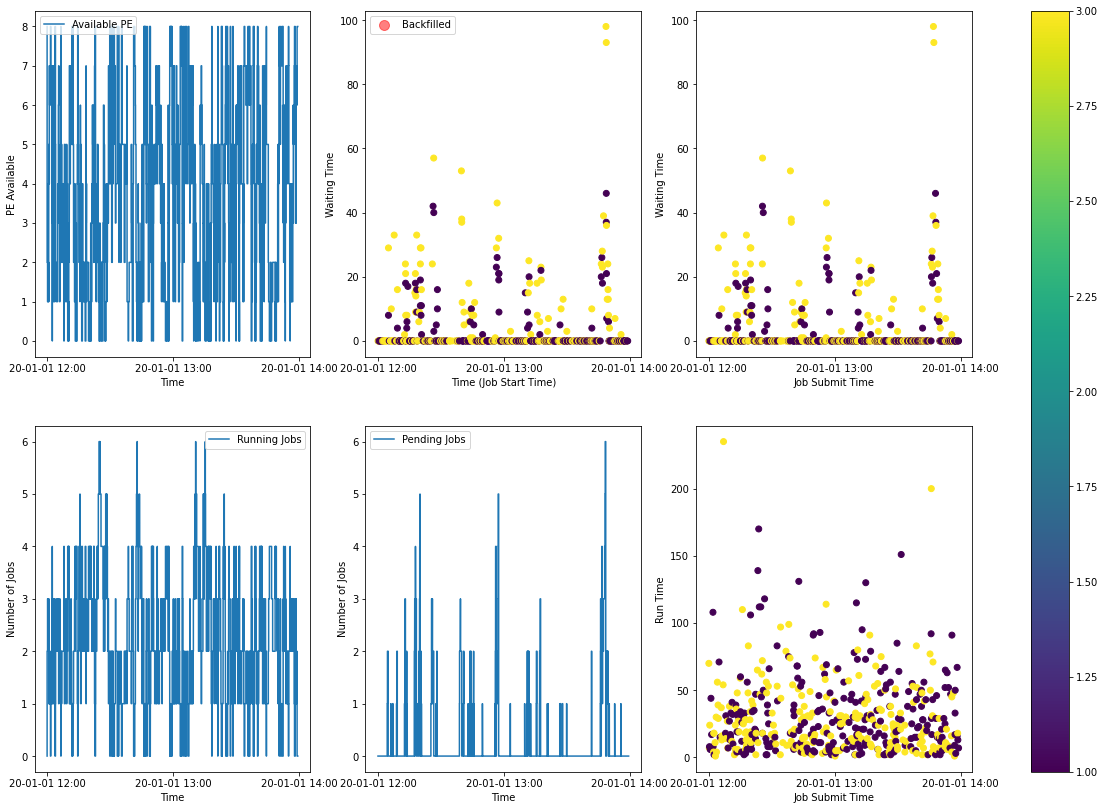

In [69]:
# Plot

fig, axs = plt.subplots(2,3, figsize = [21,14], sharex=True, sharey=False)

for ax in axs.flat:
#     ax.xaxis.set_minor_locator(mdates.AutoDateLocator(interval_multiples=True))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=1, maxticks=3))
#     ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(11,19,1))) # Finetune! Or make more auto!
#     ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(9,19,3))) # Finetune! Or make more auto!
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    
## Plot 1

ax = axs[0,0]

ax.step(df_pe.time, df_pe.pe_avail, label = "Available PE")
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('PE Available')


### Plot 2 

ax = axs[0,1]

df_jobs_backfill = df_jobs.query('slurm_comment == "Backfill"').copy()

ax.scatter(df_jobs_backfill.job_start, 
            df_jobs_backfill.wait_time, 
            s=100, marker = 'o', c='red', alpha = 0.5,
            label = "Backfilled")

plot2 = ax.scatter(df_jobs.job_start, df_jobs.wait_time, c = df_jobs.job_pe_req)

# cbar2 = plt.colorbar(plot2)
ax.legend()

ax.set_xlabel('Time (Job Start Time)')
ax.set_ylabel('Waiting Time')
# ax.clabel('PE Requested')

### Plot 3

ax = axs[0,2]
plot3 = ax.scatter(df_jobs.job_submit, df_jobs.wait_time, c = df_jobs.job_pe_req, label = "Waiting Time")

# cbar3 = plt.colorbar(plot3)
# ax.legend()

ax.set_xlabel('Job Submit Time')
ax.set_ylabel('Waiting Time')
# ax.clabel('PE Requested')

### Plot 4

ax = axs[1,0]
ax.step(df_active_jobs.time, df_active_jobs.job_count, label = "Running Jobs")
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('Number of Jobs')

# Plot 5

ax = axs[1,1]
ax.step(df_pending_jobs.time, df_pending_jobs.job_count, label = "Pending Jobs")
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('Number of Jobs')

# Plot 6

ax = axs[1,2]
# plt.scatter(df_job_starting_order.start_number, df_job_starting_order.job_pe_req, c = df_job_starting_order.job_pe_req, label = 'PE Requested')
# # plt.legend()
# plt.colorbar()
# plt.xlabel('Job start order')
# plt.ylabel('PE Requested')
# # plt.clabel('PE Requested')

plot6 = ax.scatter(df_jobs.job_submit, df_jobs.run_time, c = df_jobs.job_pe_req, label = "Waiting Time")
# cbar6 = plt.colorbar(plot6)
# plt.legend()

ax.set_xlabel('Job Submit Time')
ax.set_ylabel('Run Time')

# fig.colorbar(plot3, ax=axs) # ax=[axs[0,2], axs[1,2]])
fig.colorbar(plot3, ax=axs) # ax=[axs[0,2], axs[1,2]])

# plt.savefig(f'images/sala_qsim_{QUEUE_TYPE.lower()}_rosterplot_{run_descript}.png', 
#             facecolor='w', transparent=False)

plt.show()

In [70]:
df_jobs.tail()

,job_number,job_name,job_submit,batch_name,batch_value,job_start,job_end,job_pe_req,pe_avail,job_prio,slurm_comment,wait_time,run_time
495,495,1495,2020-01-01 13:58:20,03_Inter_13.0,13,2020-01-01 13:58:20,2020-01-01 13:59:27,1.0,8.0,1,,0.0,67.0
496,496,1496,2020-01-01 13:58:21,03_Inter_13.0,13,2020-01-01 13:58:21,2020-01-01 13:58:37,1.0,7.0,1,,0.0,16.0
497,497,1497,2020-01-01 13:58:35,03_Inter_13.0,13,2020-01-01 13:58:35,2020-01-01 13:58:53,3.0,6.0,1,,0.0,18.0
498,498,1498,2020-01-01 13:58:41,03_Inter_13.0,13,2020-01-01 13:58:41,2020-01-01 13:58:54,1.0,4.0,1,,0.0,13.0
499,499,1499,2020-01-01 13:59:01,03_Inter_13.0,13,2020-01-01 13:59:01,2020-01-01 13:59:08,1.0,7.0,1,,0.0,7.0


In [71]:
df_start = (df_jobs[['job_name', 'job_pe_req', 'job_start']]
            .rename(columns = {'job_pe_req': 'pe_req', 
                               'job_start':'event_time'})
            .assign(event_id = 10, 
                    event_type = 'start')
            .assign(comment = lambda x: x.job_name)
            .assign(pe_delta = lambda x: -1 * x.pe_req)
            .drop(columns=['pe_req', 'job_name'])
           )

df_end = (df_jobs[['job_name', 'job_pe_req', 'job_end']]
            .rename(columns = {'job_pe_req': 'pe_req', 
                               'job_end':'event_time'})
            .assign(event_id = 9, 
                    event_type = 'end')
            .assign(comment = lambda x: x.job_name)
            .assign(pe_delta = lambda x: +1 * x.pe_req)
            .drop(columns=['pe_req', 'job_name'])
           )

min_event_time = pd.to_datetime(df_start.event_time.min().value)

df_initial = pd.DataFrame({'event_time' : [min_event_time],
                           'event_id' : [0],
                           'event_type' : ['init'],
                           'comment' : [np.nan],
                           'pe_delta' : [NODE_CPUS]
                           })

# df_event = pd.concat([df_start 
df_pe_time = (pd.concat([df_initial, 
                        df_start, 
                        df_end])
             .sort_values(['event_time', 'event_id', 'comment'])
             .reset_index(drop=True)
            )

# calculate available pe

df_pe_time['pe_avail'] = df_pe_time.pe_delta.cumsum()
df_pe_time['pe_avail_norm'] = df_pe_time.pe_avail /  df_pe_time.pe_avail.max()

df_pe_time.head(20)

,event_time,event_id,event_type,comment,pe_delta,pe_avail,pe_avail_norm
0,2020-01-01 12:00:03,0,init,NaN,8.0,8.0,1.000
1,2020-01-01 12:00:03,10,start,1000.0,-3.0,5.0,0.625
2,2020-01-01 12:00:15,10,start,1001.0,-3.0,2.0,0.250
3,2020-01-01 12:00:20,10,start,1002.0,-1.0,1.0,0.125
4,2020-01-01 12:00:22,9,end,1001.0,3.0,4.0,0.500
5,2020-01-01 12:00:28,9,end,1002.0,1.0,5.0,0.625
6,2020-01-01 12:00:28,10,start,1003.0,-3.0,2.0,0.250
7,2020-01-01 12:00:41,10,start,1004.0,-1.0,1.0,0.125
8,2020-01-01 12:00:47,9,end,1004.0,1.0,2.0,0.250
9,2020-01-01 12:00:50,10,start,1005.0,-1.0,1.0,0.125


In [72]:
df_pe_time['event_time'] = (
    df_pe_time['event_time'] 
    - min_event_time 
    + pd.to_datetime("2020-01-01 12:00:00"))

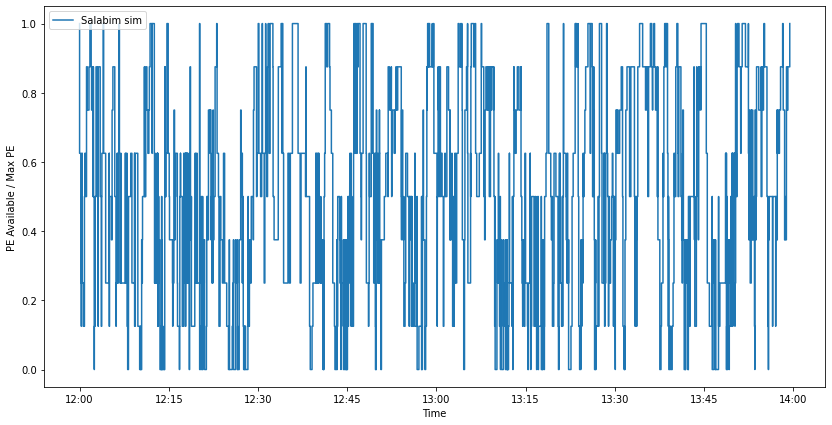

Total Backfills: 0


In [73]:
# Plot graph

fig, ax = plt.subplots(figsize=[14,7])

# for ax in axs.flat:
# #     ax.xaxis.set_minor_locator(mdates.AutoDateLocator(interval_multiples=True))
#     ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=4))
# #     ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(11,19,1))) # Finetune! Or make more auto!
# #     ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(9,19,3))) # Finetune! Or make more auto!
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

# ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=5))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

## Plot 1

# ax = axs[0,0]

ax.step(df_pe_time.event_time, 
        df_pe_time.pe_avail_norm,
        where='post',  # Baie NB!
        label = "Salabim sim")

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel(r'PE Available / Max PE')

# SAVE STUFF
if save_data:
    pltpath = f'{save_image_path}/{run_type}_{run_short}_{run_model}_pe_time_plot.png'
    plt.savefig(pltpath, facecolor='w', transparent=False)

# Show plot
plt.show()

backfill_count = df_jobs.query("slurm_comment == 'Backfill'").shape[0]
print(f"Total Backfills: {backfill_count}")

In [74]:
# Add backfill column to jobs
df_jobs['backfill'] = np.where(df_jobs.slurm_comment == 'Backfill', 1, 0)

In [75]:
# Save data

if save_data:
    df_jobs.to_pickle(f"{save_data_path}/{run_type}_{run_short}_{run_model}_dfjobs.pkl")
    df_pe_time.to_pickle(f"{save_data_path}/{run_type}_{run_short}_{run_model}_dfpetime.pkl")

# WAIT TIME PER BATCH

In [76]:
# SETTINGS
n_warmup_exclude = 0    # exclude the first 10 jobs a batch
n_cooldown_exclude = 0   # exclude last jobs of a batch. does not include the batch splitting job

# FUNCTION
def drop_warmup_cooldown_jobs(df):
    if n_cooldown_exclude > 0:
        return df.iloc[n_warmup_exclude:-n_cooldown_exclude]
    else: 
        return df.iloc[n_warmup_exclude:]
        # drops first n_warmup_exclude rows, and the last n_cooldown_exclude rows 

In [77]:
# Job Batch Info
df_job_batch = (df_jobs
                .loc[:, ['job_name', 'batch_name', 'batch_value']]
                .query("batch_value >= 0")
                .groupby(['batch_name', 'batch_value'], group_keys=False)
                .apply(drop_warmup_cooldown_jobs)
                .copy()
                .reset_index(drop=True)
               )

# Job indices
df_job_idx = df_job_batch.loc[:, ['job_name']]

# summary of job counts
(df_jobs
 .merge(df_job_idx.assign(STATE = "USED"), on="job_name", how="inner")
 .groupby(['batch_name', 'batch_value', "STATE"])
 .agg({"job_name": ["min", "max", "count"]
        })
) # .head()

job_name            
                                     min   max count
batch_name    batch_value STATE                     
03_Inter_13.0 13          USED      1000  1499   500

In [78]:
# df_jobs

In [79]:
table_wait=(df_jobs
 .merge(df_job_idx, on="job_name", how="inner")
 .loc[:, ['batch_name', 'batch_value', 'job_number', 'job_pe_req', 'job_prio', 'wait_time', 'run_time', 'backfill']]
 .groupby(['batch_name', 'batch_value'])
 .agg({
       # "wait_time": ["min", "mean", "max"],
      "wait_time": ["mean", "median"],
       "run_time" : ["mean"],
       "job_pe_req" : ["mean"],
       'job_number' : ["count"],
       "backfill" : ["sum"]
        })
#  .rename(columns={"job_pe_req":"jobs"})
)

# table_wait.to_csv(f"tables/{run_name}~SimPE.csv")

# ATTEMPT TO ADD RHO
table_wait = table_wait.reset_index(drop=False)
table_wait["est_lam"] = (1 / table_wait["batch_value"])
table_wait["est_c"] = (NODE_CPUS / table_wait["job_pe_req"]["mean"])
table_wait["est_mu"] = (1 / table_wait["run_time"]["mean"]) * table_wait["est_c"]
table_wait["est_rho"] =  table_wait["est_lam"] / table_wait["est_mu"]

# table_wait.columns = table_wait.columns.map('_'.join)

table_wait

batch_name batch_value wait_time        run_time job_pe_req job_number  \
                                  mean median     mean       mean      count   
0  03_Inter_13.0          13     4.144    0.0   30.232      1.972        500   

  backfill   est_lam     est_c    est_mu   est_rho  
       sum                                          
0        0  0.076923  4.056795  0.134189  0.573245

In [80]:
table_wait2=(df_jobs
 .merge(df_job_idx, on="job_name", how="inner")
 .loc[:, ['batch_name', 'batch_value', 'job_number', 'job_pe_req', 'job_prio', 'wait_time', 'run_time', 'backfill']]
 .groupby(['batch_name', 'batch_value', 'job_prio', 'job_pe_req'])
 .agg({
       # "wait_time": ["min", "mean", "max"],
      "wait_time": ["mean"],
       "run_time" : ["mean"],
       "job_pe_req" : ["mean"],
       "job_number" : ["count"],
       "backfill" : ["sum"]
        })
#  .rename(columns={"job_pe_req":"jobs"})
)

# table_wait2

In [81]:
table_wait_prio=(df_jobs
 .merge(df_job_idx, on="job_name", how="inner")
 .loc[:, ['batch_name', 'batch_value', 'job_pe_req', 'job_prio', 'wait_time', 'run_time', 'backfill']] 
#  .groupby(['job_prio', 'job_interarrival_mean'])
 .groupby(['batch_name', 'batch_value', 'job_prio'])
 .agg({"wait_time": ["mean"],
       "run_time" : ["mean"],
       "job_pe_req" : ["count","mean"],
       "backfill" : ["sum"]
        })
#  .rename(columns={"job_pe_req":"jobs"})
)

# # ATTEMPT TO ADD RHO
# table_wait_prio = table_wait_prio.reset_index(drop=False)
# table_wait_prio["est_lam"] = (1 / table_wait_prio["batch_value"])
# table_wait_prio["est_c"] = (NODE_CPUS / table_wait_prio["job_pe_req"]["mean"])
# table_wait_prio["est_mu"] = (1 / table_wait_prio["run_time"]["mean"]) * table_wait_prio["est_c"]
# table_wait_prio["est_rho"] =  table_wait_prio["est_lam"] / table_wait_prio["est_mu"]

# table_wait_prio = table_wait_prio.drop(columns = ['est_lam', 'est_mu'], level=0)

# table_wait.to_csv(f"tables/{run_name}~SimPE.csv")

table_wait_prio

wait_time run_time job_pe_req         \
                                        mean     mean      count   mean   
batch_name    batch_value job_prio                                        
03_Inter_13.0 13          1            4.144   30.232        500  1.972   

                                   backfill  
                                        sum  
batch_name    batch_value job_prio           
03_Inter_13.0 13          1               0

In [82]:
# 50th Percentile
def q50(x):
    return x.quantile(0.75)

def q75(x):
    return x.quantile(0.75)

# 90th Percentile
def q90(x):
    return x.quantile(0.9)

table_wait_prio_pe=(df_jobs
 .merge(df_job_idx, on="job_name", how="inner") 
 .loc[:, ['batch_name', 'batch_value', 'job_pe_req', 'job_prio', 'wait_time', 'run_time', 'backfill']]
 .groupby(['batch_name', 'batch_value', 'job_prio', 'job_pe_req'])
#  .groupby(['job_prio', 'job_pe_req', 'job_interarrival_mean'])
 .agg({"wait_time": ["mean", q75, q90, "max"],
       "run_time" : ["mean"],
       "job_pe_req" : ["count"],
       "backfill" : ["sum"]
        })
 .rename(columns={"job_pe_req":"job"})
)

# table_wait.to_csv(f"tables/{run_name}~SimPE.csv")

table_wait_prio_pe

wait_time                   \
                                                   mean  q75   q90   max   
batch_name    batch_value job_prio job_pe_req                              
03_Inter_13.0 13          1        1.0         2.630350  0.0   9.4  46.0   
                                   3.0         5.744856  6.0  22.6  98.0   

                                                run_time   job backfill  
                                                    mean count      sum  
batch_name    batch_value job_prio job_pe_req                            
03_Inter_13.0 13          1        1.0         31.972763   257        0  
                                   3.0         28.390947   243        0

# Estimate arrivals and completion rate

$$\pi_0 = [\sum_{k=0}^{c} \frac{\lambda^k}{\mu^k k!} + \frac{\lambda^c}{\mu^c c!}\sum_{k=c+1}^K \frac{\lambda^{k-c}}{\mu^{k-c} c^{k-c}}]^{-1}$$

$$W_q = \pi_0 \frac{\rho (c\rho)^c}{\lambda (1-\rho)^2 c!}$$

That's for the finite queue case ... let's try the infinite case.

$$P_0 = [\sum_{m=0}^{c-1} \frac {(c\rho)^m}{m!} + \frac{(c\rho)^c}{c!(1-\rho)}]^{-1}$$ 

$$W_q = P_0 \frac{\rho (c\rho)^c}{\lambda (1-\rho)^2 c!}$$

In [83]:
from math import factorial

c = 2
lam = 1 / 8  # combined job arrival.
mu_1server = 1 / 10  
mu = c * mu_1server

# example
# c = 2 
# lam = 1 / 10
# mu_1server = 1/15
# mu = c * mu_1server

rho = lam / mu

print(f"rho: {rho:.2f}")

rho: 0.62


In [84]:
p_0_term1 = 0

for m in range(c-1):
    p_0_term1 += (c ** rho)**m / (factorial(m))
    
p_0_term2 = ((c*rho)**c) / (factorial(c) * (1 - rho))
    
p_0 = 1 / (p_0_term1 + p_0_term2)

print(p_0) # This seems wrong ... 

0.3243243243243243


In [85]:
w_q = p_0 * (rho * (c * rho) ** c) / (lam * (1 - rho)**2 * factorial(c))
print(f"waiting time: {w_q:.2f}")

waiting time: 9.01


In [86]:
# vlam = [lam, 0]
# vmu = [mu, mu]
# vrho = [l / m for l,m in zip(vlam, vmu)]
# rho = sum(vrho)

# R = rho / mu

# print("Prio: [10, 1]")
# print(f"lam's: {vlam}")
# print(f"mu's: {vmu}")
# print(f"rho's: {vrho}")
# print(f"rho: {rho}")
# print("")
# print(f"R : {R}")

In [87]:
# w_high = R / (1-vrho[0])
# w_low = R / ((1-vrho[0])*(1-vrho[0]-vrho[1]))

# W = [w_high, w_low]

# print(f'10s runtime. Rho High={(100*vrho[0]):.0f}. Wait={w_high:.1f}')
# print(f'10s runtime. Rho Low={(100*vrho[1]):.0f}: Wait={w_low:.1f}')

# UTILISATION PER BATCH

In [88]:
# Add Batch Info to PE time
df_saturation=df_pe_time
df_saturation['job_name'] = df_saturation['comment'].astype("Int64")

df_job_batch_join = df_job_batch.loc[:, ['job_name', 'batch_name', 'batch_value']].copy()
df_job_batch_join['job_name'] = df_job_batch_join.job_name.astype('Int64')

# Time 
df_saturation['time_till_next'] = df_saturation.event_time.shift(-1) - df_saturation.event_time
df_saturation['seconds_till_next'] = df_saturation.time_till_next.dt.total_seconds()
df_saturation['pe_avail_time'] = df_saturation.seconds_till_next * df_saturation.pe_avail
df_saturation['pe_avail_time_norm'] = df_saturation.seconds_till_next * df_saturation.pe_avail_norm

# Filter on Job Indexes
df_saturation_filter=(df_saturation               
                .merge(df_job_batch_join, how='inner', on='job_name')
              )

# Calculate 
table_rho = (df_saturation_filter
#              .groupby(['event_type','job_interarrival_mean'])
             .groupby(['batch_name', 'batch_value'])
             .agg({"event_type": ["count"] ,
                   "pe_avail_time" : ["sum"],
                   "pe_avail_time_norm" : ["sum"],
                   "event_time" : ["min", "max"]
                })
            )

table_rho.reset_index(drop=False)

table_rho["time_span"] = table_rho['event_time']['max'] - table_rho['event_time']['min']
table_rho["time_span"] = table_rho.time_span.dt.total_seconds()
table_rho["avg_PE_avail"] = table_rho['pe_avail_time']['sum'] / table_rho["time_span"]
table_rho["avg_PE_avail_norm"] = table_rho['pe_avail_time_norm']['sum'] / table_rho["time_span"]
table_rho["avg_PE_used_norm"] = 1-table_rho["avg_PE_avail_norm"]

table_rho["job_count"] = table_rho["event_type"]["count"].div(2).astype(int)

# Select Columns
# table_rho = table_rho.loc[:, ["job_count", "event_time", "avg_PE_avail", "avg_PE_avail_norm", "avg_PE_used_norm"]]
table_rho = table_rho.loc[:, ["job_count", "time_span", "avg_PE_used_norm"]]

#Flatten Multi-index (NICE)
table_rho.columns = ["_".join(c) if c[1] != "" else c[0] for c in table_rho.columns.to_flat_index()] 

# Remove lowest job_interarrival -> since will be biased by cooldown
# table_rho = table_rho.loc[table_rho.index != table_rho.index.min(), :]

table_rho

,,job_count,time_span,avg_PE_used_norm
batch_name,batch_value,,,
03_Inter_13.0,13,500,7164.0,0.504502


In [89]:
# Calculate 
table_rho_prio = (df_saturation_filter
#              .groupby(['event_type','job_interarrival_mean'])
             .groupby(['batch_name', 'batch_value'])
             .agg({"event_type": ["count"] ,
                   "pe_avail_time" : ["sum"],
                   "pe_avail_time_norm" : ["sum"],
                   "event_time" : ["min", "max"]
                })
            )

table_rho_prio.reset_index(drop=False)

table_rho_prio["time_span"] = table_rho_prio['event_time']['max'] - table_rho_prio['event_time']['min']
table_rho_prio["time_span"] = table_rho_prio.time_span.dt.total_seconds()
table_rho_prio["avg_PE_avail"] = table_rho_prio['pe_avail_time']['sum'] / table_rho_prio["time_span"]
table_rho_prio["avg_PE_avail_norm"] = table_rho_prio['pe_avail_time_norm']['sum'] / table_rho_prio["time_span"]
table_rho_prio["avg_PE_used_norm"] = 1-table_rho_prio["avg_PE_avail_norm"]

table_rho_prio["job_count"] = table_rho_prio["event_type"]["count"].div(2).astype(int)

# Select Columns
table_rho_prio = table_rho_prio.loc[:, 
                                    ["job_count", "event_time", "avg_PE_avail", 
                                     "avg_PE_avail_norm", "avg_PE_used_norm"]]
table_rho_prio = table_rho_prio.loc[:, ["job_count", "avg_PE_used_norm"]]

#Flatten Multi-index (NICE)
table_rho_prio.columns = ["_".join(c) if c[1] != "" else c[0] for c in table_rho_prio.columns.to_flat_index()] 

# table_rho_prio

In [90]:
## SOMETHING SEEMS SLIGHTLY WRONG HERE .... 
## I SHOULD BE GROUPING BY THE ORDER OF JOBS INSTEAD OF THE job_interarrival_mean
## OTHERWISE THE PE_TIME CALC WILL BE WRONG!!!

## ALSO: The cooldown jobs should be excluded ideally

In [91]:
# df_pe_time

In [92]:
df_est_lam = (df_pe_time
          .query("event_type == 'start'")
          .loc[:, ['event_time', 'event_type', 'job_name']]
          .copy()
         )

df_est_lam['delta'] = df_est_lam.event_time - df_est_lam.event_time.shift(1)
df_est_lam['delta'] = df_est_lam.delta.dt.total_seconds()
job_start_interval = df_est_lam.delta.mean()

PE_max = df_jobs.pe_avail.max()
PE_avg = df_jobs.job_pe_req.mean()
est_server_count =  PE_max / PE_avg

est_job_int = df_est_lam.delta.mean()
est_lam = 1 / est_job_int

est_job_run = df_jobs.run_time.mean()
est_mu = (1 / est_job_run) * est_server_count # hierdie is al wat werk volgens my! 
est_rho = est_lam / est_mu
print(f"est_c: {est_server_count}")
print(f"est_job_int: {est_job_int}")
print(f"est_lam: {est_lam}")
print(f"est_mu: {est_mu}")
print(f"rho estimate: {est_rho}")  # this doesn't seem to work.

est_c: 4.056795131845842
est_job_int: 14.304609218436873
est_lam: 0.06990753712524517
est_mu: 0.13418877784618424
rho estimate: 0.5209641092743065


In [93]:
# # Estimate Job Completions
# df_est_lam = (df_pe_time
#           .query("event_type == 'start'")
#           .loc[:, ['event_time', 'event_type', 'job_name']]
#           .copy()
#          )

# df_est_lam['delta'] = df_est_lam.event_time - df_est_lam.event_time.shift(1)
# df_est_lam['delta'] = df_est_lam.delta.dt.total_seconds()
# job_start_interval = df_est_lam.delta[100:9900].mean()

# # del df_est_lam

# # Estimate Job interval (over all servers)
# df_est_mu = (df_pe_time
#           .query("event_type == 'end'")
#           .loc[:, ['event_time', 'event_type', 'job_name']]
#           .copy()
#          )

# df_est_mu['delta'] = df_est_mu.event_time - df_est_mu.event_time.shift(1)
# df_est_mu['delta'] = df_est_mu.delta.dt.total_seconds()

# job_end_interval = df_est_mu.delta[100:9900].mean()

# # del df_est_mu

# print(f"job start interval: {job_start_interval}")
# print(f"job end interval: {job_end_interval}")
# print(f"rho estimate: {job_end_interval/job_start_interval}")

## Extra info for Prio2

In [94]:
df_prio2_info = (df_jobs.merge(df_job_idx, on="job_name", how="inner")
 .loc[:, ['batch_name', 'batch_value', 'job_pe_req', 'job_prio', 'wait_time', 'run_time', 'backfill']]
 .groupby(['batch_name', 'batch_value', 'job_pe_req', 'job_prio'])
 .wait_time
 .describe(percentiles=[0.25,0.5,0.75,0.9]))
                 
df_prio2_info

count      mean        std  \
batch_name    batch_value job_pe_req job_prio                               
03_Inter_13.0 13          1.0        1         257.0  2.630350   7.244039   
                          3.0        1         243.0  5.744856  13.136313   

                                               min  25%  50%  75%   90%   max  
batch_name    batch_value job_pe_req job_prio                                  
03_Inter_13.0 13          1.0        1         0.0  0.0  0.0  0.0   9.4  46.0  
                          3.0        1         0.0  0.0  0.0  6.0  22.6  98.0

In [95]:
# del df_jobs
# del df_pe_time